In [1]:
from SALib.analyze.sobol import analyze
from SALib.sample.sobol import sample
from SALib.util import ProblemSpec

import numpy as np
from multiprocessing import Pool
import matplotlib.pyplot as plt

In [2]:
t = np.arange(0, 40.1, 0.1)


def linear_function(t: np.ndarray, a: float, b: float):
    return a * t + b


def wrapped(X):
    a, b = X
    return linear_function(t, a, b)

In [3]:
# Define the model inputs
names = ["a", "b"]

problem = ProblemSpec(
    num_vars=len(names),
    names=names,
    bounds=[
        [-1, 1],
        [-10, 10],
    ],
)

In [4]:
# Generate samples
param_values = sample(problem, 1024)
param_values

array([[ 0.06031472, -3.12305707],
       [-0.39127972, -3.12305707],
       [ 0.06031472, -0.35606485],
       ...,
       [ 0.06113351, -4.12543047],
       [ 0.92501336,  1.41451163],
       [ 0.92501336, -4.12543047]])

In [5]:
# Run model (example)
with Pool() as pool:
    Y = pool.map(wrapped, param_values)

ndY = np.array(Y)
Si = [analyze(problem, Y) for Y in ndY.T]

In [7]:
fo_names = problem["names"]
first_order = np.array([s["S1"] for s in Si]).T
fo_confidence = np.array([s["S1_conf"] for s in Si]).T

so_names = [f"{fo_names[0]}, {fo_names[1]}"]
second_order = np.array([[s["S2"][0, 1] for s in Si]])
so_confidence = np.array([[s["S2_conf"][0, 1] for s in Si]])

tot_names = fo_names
tot_order = np.array([s["ST"] for s in Si]).T
tot_confidence = np.array([s["ST_conf"] for s in Si]).T

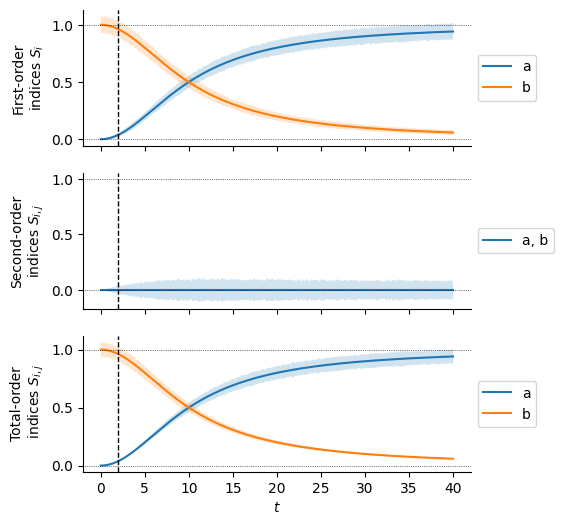

In [10]:
t_select = 2
tidx = np.argmin(np.abs(t - t_select))

fig, axs = plt.subplots(
    3,
    1,
    sharex="col",
    sharey="row",
    figsize=(5, 6),
)

ax = axs[0]
for name, si, conf in zip(fo_names, first_order, fo_confidence):
    ax.plot(t, si, label=name)
    ax.fill_between(t, si - conf, si + conf, alpha=0.2)
    ax.set_ylabel("First-order\nindices $S_i$")


ax = axs[1]
for name, si, conf in zip(so_names, second_order, so_confidence):
    ax.plot(t, si, label=name)
    ax.fill_between(t, si - conf, si + conf, alpha=0.2)
    ax.set_ylabel("Second-order\nindices $S_{i,j}$")

ax = axs[2]
for name, si, conf in zip(tot_names, tot_order, tot_confidence):
    ax.plot(t, si, label=name)
    ax.fill_between(t, si - conf, si + conf, alpha=0.2)
    ax.set_ylabel("Total-order\n indices $S_{i,j}$")

ax.set_xlabel("$t$")

for ax in axs.flatten():
    ax.axhline(1, color="gray", ls="dotted", lw=0.5, c="k")
    ax.axhline(0, color="gray", ls="dotted", lw=0.5, c="k")
    ax.axvline(x=t_select, c="k", lw=1, ls="dashed")
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

    ax.spines.top.set_visible(False)
    ax.spines.right.set_visible(False)

plt.show()

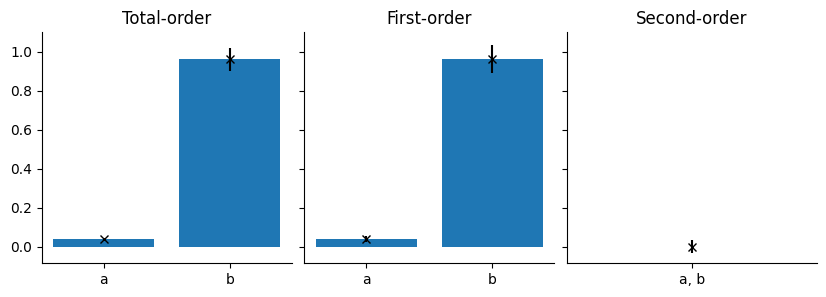

In [9]:
fig, axs = plt.subplots(
    1, 3, figsize=(10, 3), sharey=True, gridspec_kw={"wspace": 0.05}
)

ax = axs[0]
dummy_x = np.arange(len(tot_names))
ax.bar(dummy_x, tot_order.T[tidx])
ax.errorbar(
    dummy_x,
    tot_order.T[tidx],
    yerr=tot_confidence.T[tidx],
    fmt="x",
    color="k",
)
ax.set_xticks(dummy_x)
ax.set_xticklabels(tot_names)
ax.set_title("Total-order")

ax = axs[1]
dummy_x = np.arange(len(fo_names))
ax.bar(dummy_x, first_order.T[tidx])
ax.errorbar(
    dummy_x,
    first_order.T[tidx],
    yerr=fo_confidence.T[tidx],
    fmt="x",
    color="k",
)
ax.set_xticks(dummy_x)
ax.set_xticklabels(fo_names)
ax.set_title("First-order")

ax = axs[2]
dummy_x = np.arange(len(so_names))
ax.bar(dummy_x, second_order.T[tidx])
ax.errorbar(
    dummy_x,
    second_order.T[tidx],
    yerr=so_confidence.T[tidx],
    fmt="x",
    color="k",
)
ax.set_xticks(dummy_x)
ax.set_xticklabels(so_names)
ax.set_title("Second-order")

for ax in axs:
    ax.spines.top.set_visible(False)
    ax.spines.right.set_visible(False)
    ax.set_ylim(top=1.1)

plt.show()